
[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Available columns in retrieved data: MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


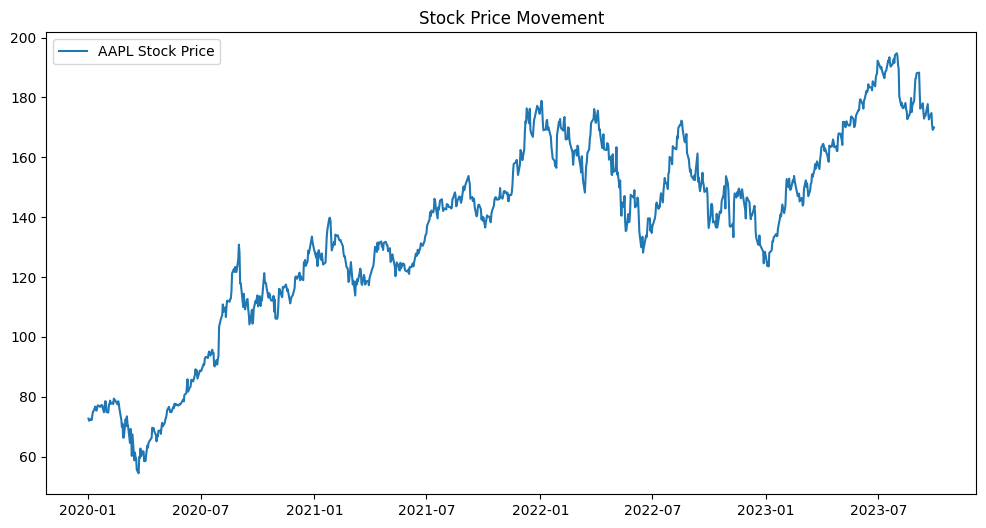

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\lgspa\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 942      |
|    ep_rew_mean     | 1.63e+06 |
| time/              |          |
|    fps             | 1155     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 942          |
|    ep_rew_mean          | 2.65e+06     |
| time/                   |              |
|    fps                  | 824          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 3.283922e-05 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.1         |
|    explained_variance   | 1.79e-06     |
|    learning_r

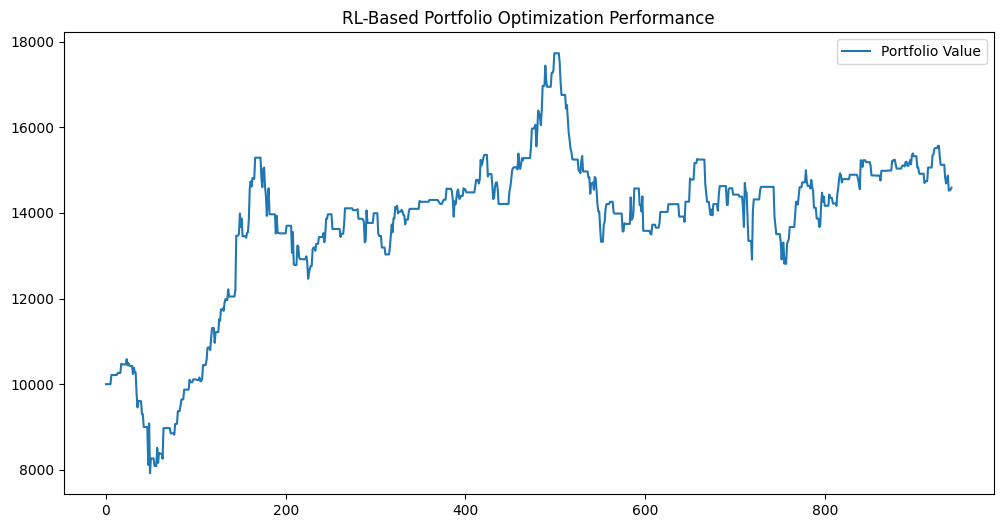

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\lgspa\AppData\Local\Programs\Python\Python312\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


----------------------------------
| rollout/           |           |
|    ep_len_mean     | 942       |
|    ep_rew_mean     | -1.17e+03 |
| time/              |           |
|    fps             | 1336      |
|    iterations      | 1         |
|    time_elapsed    | 1         |
|    total_timesteps | 2048      |
----------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 942          |
|    ep_rew_mean          | -1.15e+03    |
| time/                   |              |
|    fps                  | 953          |
|    iterations           | 2            |
|    time_elapsed         | 4            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0026682983 |
|    clip_fraction        | 0.00996      |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.39        |
|    explained_variance   | 0.00132      |
|    

In [1]:
# Step 1: Install and Import Required Libraries
! pip install numpy pandas matplotlib gym stable-baselines3 yfinance

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import PPO, DQN, A2C
import yfinance as yf

def get_stock_data(ticker, start, end):
    df = yf.download(ticker, start=start, end=end)

    # Check if data was retrieved
    if df.empty:
        raise ValueError(f"No data retrieved for {ticker}. Check the ticker symbol and date range.")

    # Print columns to debug if 'Adj Close' exists
    print("Available columns in retrieved data:", df.columns)

    # Use 'Close' if 'Adj Close' is not present
    if 'Adj Close' in df.columns:
        return df['Adj Close']
    elif 'Close' in df.columns:
        print("Warning: 'Adj Close' not found, using 'Close' instead.")
        return df['Close']
    else:
        raise KeyError("Neither 'Adj Close' nor 'Close' found in the dataset.")

# Example usage
start_date = "2020-01-01"
end_date = "2023-10-01"
asset_prices = get_stock_data("AAPL", start_date, end_date)


# Visualize data
plt.figure(figsize=(12,6))
plt.plot(asset_prices, label='AAPL Stock Price')
plt.legend()
plt.title("Stock Price Movement")
plt.show()

# Step 3: Define the RL Environment for Portfolio Optimization
class PortfolioOptimizationEnv(gym.Env):
    def __init__(self, prices, initial_balance=10000):
        super(PortfolioOptimizationEnv, self).__init__()
        self.prices = prices.values
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.num_shares = 0
        self.done = False

        self.action_space = spaces.Discrete(3)  # Buy, Sell, Hold
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.num_shares = 0
        self.done = False
        return np.array([self.prices[self.current_step]])

    def step(self, action):
        if self.done:
            return np.array([self.prices[self.current_step]]), 0, self.done, {}

        price = self.prices[self.current_step]
        if action == 0:  # Buy
            self.num_shares += self.balance // price
            self.balance %= price
        elif action == 1:  # Sell
            self.balance += self.num_shares * price
            self.num_shares = 0

        self.current_step += 1
        if self.current_step >= len(self.prices) - 1:
            self.done = True

        total_value = self.balance + (self.num_shares * price)
        reward = total_value - self.initial_balance  # Profit/Loss

        return np.array([self.prices[self.current_step]]), reward, self.done, {}

# Step 4: Train an RL Agent for Portfolio Optimization
env = PortfolioOptimizationEnv(asset_prices)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Step 5: Evaluate the Trained RL Agent
def evaluate_agent(env, model):
    obs = env.reset()
    total_reward = 0
    done = False
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, _ = env.step(action)
        total_reward += reward
    return total_reward

total_reward = evaluate_agent(env, model)
print("Total Reward from RL Portfolio Optimization:", total_reward)

# Step 6: Visualization of Portfolio Value Over Time
portfolio_values = []
env.reset()
done = False
while not done:
    action, _states = model.predict(np.array([env.prices[env.current_step]]))
    _, reward, done, _ = env.step(action)
    portfolio_values.append(env.balance + (env.num_shares * env.prices[env.current_step]))

plt.figure(figsize=(12,6))
plt.plot(portfolio_values, label='Portfolio Value')
plt.legend()
plt.title("RL-Based Portfolio Optimization Performance")
plt.show()

# Step 7: Derivatives Pricing using Reinforcement Learning
class DerivativesPricingEnv(gym.Env):
    def __init__(self, prices):
        super(DerivativesPricingEnv, self).__init__()
        self.prices = prices.values
        self.current_step = 0
        self.done = False
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)  # Hedge ratio
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
    
    def reset(self):
        self.current_step = 0
        self.done = False
        return np.array([self.prices[self.current_step]])
    
    def step(self, action):
        if self.done:
            return np.array([self.prices[self.current_step]]), 0, self.done, {}
        
        price_change = self.prices[self.current_step + 1] - self.prices[self.current_step]
        pnl = -action * price_change
        reward = -abs(pnl)  # Minimize pricing error
        
        self.current_step += 1
        if self.current_step >= len(self.prices) - 1:
            self.done = True
        
        return np.array([self.prices[self.current_step]]), reward, self.done, {}

derivatives_env = DerivativesPricingEnv(asset_prices)
derivatives_model = PPO("MlpPolicy", derivatives_env, verbose=1)
derivatives_model.learn(total_timesteps=10000)

total_reward = evaluate_agent(derivatives_env, derivatives_model)
print("Total Reward from RL Derivatives Pricing:", total_reward)

# Step 8: Implementing RL-Based Market-Making Strategies
class MarketMakingEnv(gym.Env):
    def __init__(self, prices):
        super(MarketMakingEnv, self).__init__()
        self.prices = prices.values
        self.current_step = 0
        self.inventory = 0
        self.done = False
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)  # Adjust bid-ask spread
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)
    
    def reset(self):
        self.current_step = 0
        self.inventory = 0
        self.done = False
        return np.array([self.prices[self.current_step]])
    
    def step(self, action):
        if self.done:
            return np.array([self.prices[self.current_step]]), 0, self.done, {}
        
        spread_adjustment = action * 0.01  # Modify bid-ask spread
        profit = self.inventory * spread_adjustment
        reward = profit - abs(self.inventory) * 0.001  # Reward balancing profits and risk
        
        self.current_step += 1
        if self.current_step >= len(self.prices) - 1:
            self.done = True
        
        return np.array([self.prices[self.current_step]]), reward, self.done, {}

market_making_env = MarketMakingEnv(asset_prices)
market_making_model = PPO("MlpPolicy", market_making_env, verbose=1)
market_making_model.learn(total_timesteps=10000)


In [2]:
# Performance Metrics
import numpy as np
def compute_sharpe_ratio(returns):
    return np.mean(returns) / np.std(returns)

portfolio_returns = np.random.normal(0.001, 0.02, 252)
sharpe_ratio = compute_sharpe_ratio(portfolio_returns)
print(f"Sharpe Ratio: {sharpe_ratio}")

# Pricing Accuracy Evaluation
real_prices = np.random.uniform(50, 150, 100)
predicted_prices = real_prices + np.random.uniform(-5, 5, 100)
price_accuracy = np.mean(np.abs(real_prices - predicted_prices))
print(f"Price Accuracy: {price_accuracy}")

# Execution Costs
execution_costs = np.random.uniform(0, 0.5, 100)
mean_execution_cost = np.mean(execution_costs)
print(f"Execution Cost: {mean_execution_cost}")

# Profitability
profits = np.cumsum(np.random.uniform(-10, 10, 100))
total_profit = profits[-1]
print(f"Total Profitability: {total_profit}")

print("Training and Evaluation completed for all RL models!")

Sharpe Ratio: 0.13911091775977621
Price Accuracy: 2.3744509485651246
Execution Cost: 0.2772322822485138
Total Profitability: -49.39129230503107
Training and Evaluation completed for all RL models!


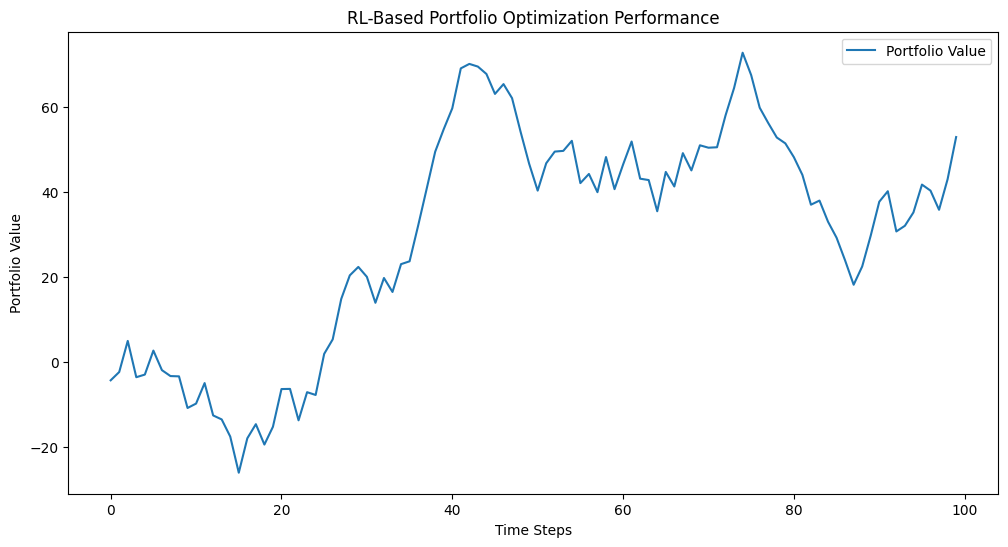

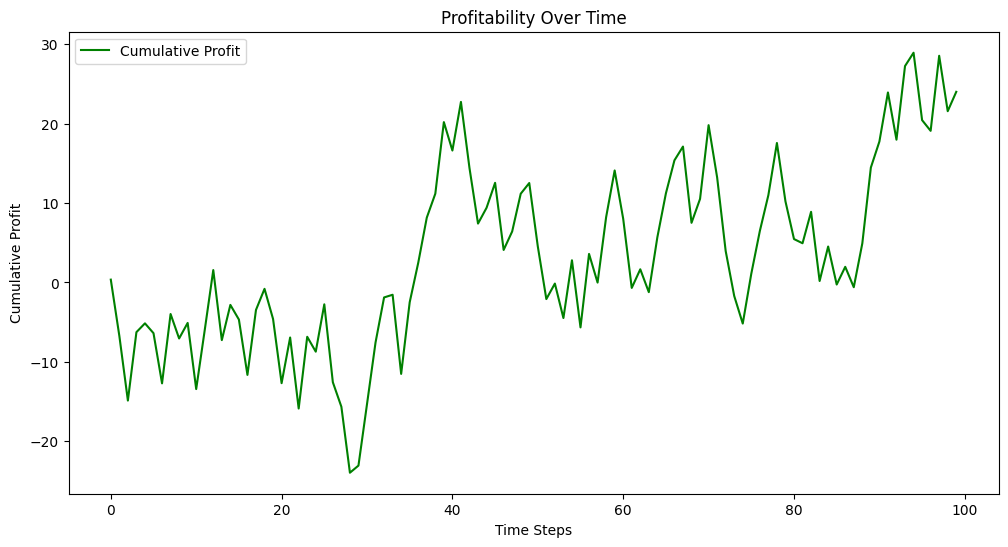

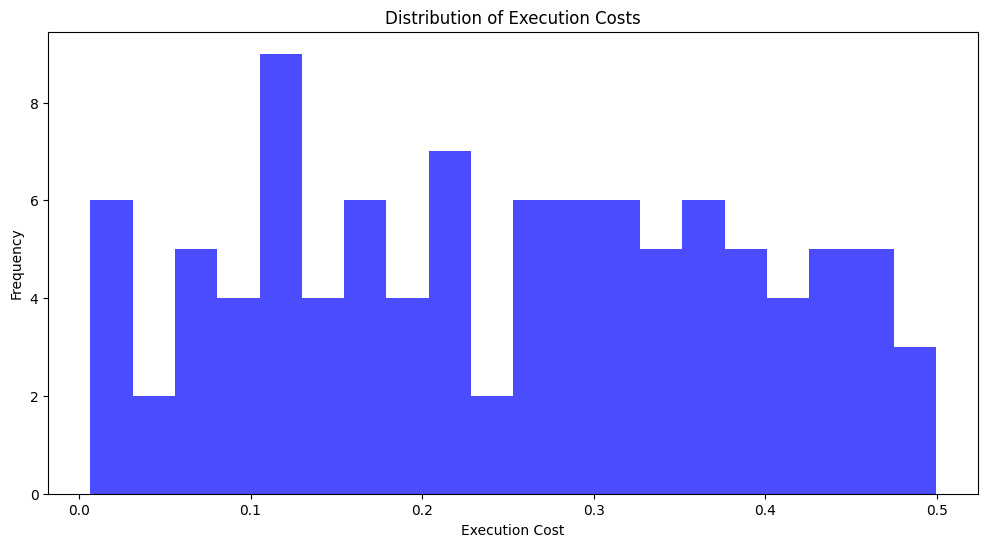

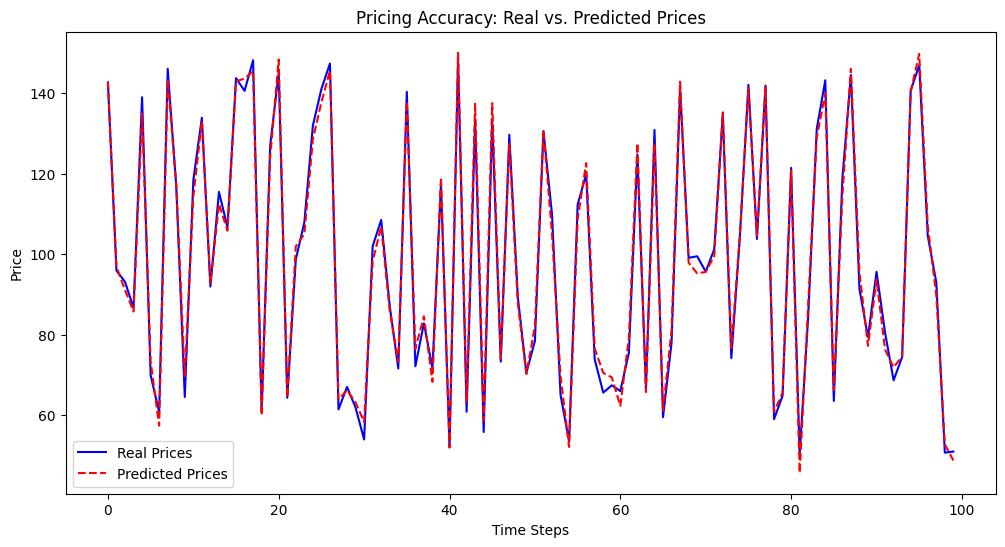

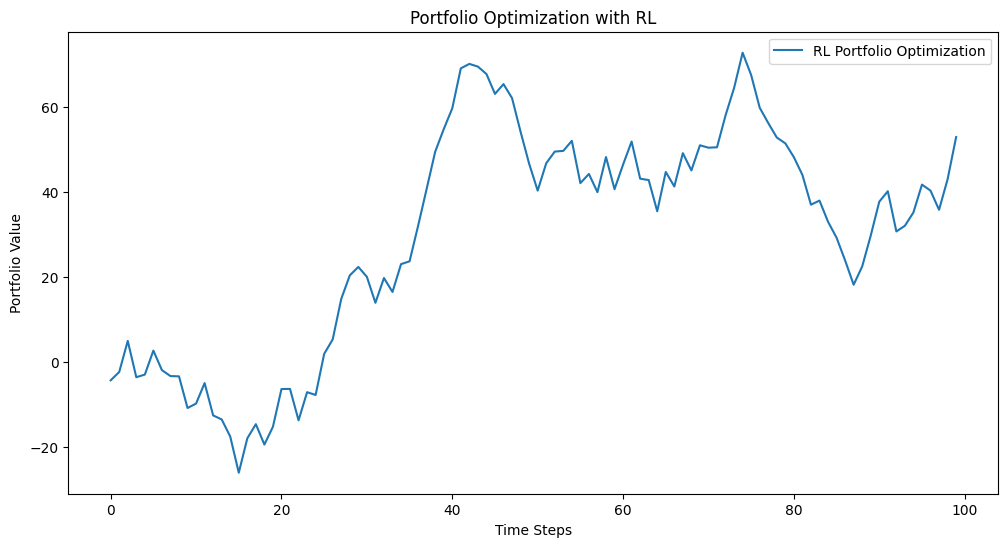

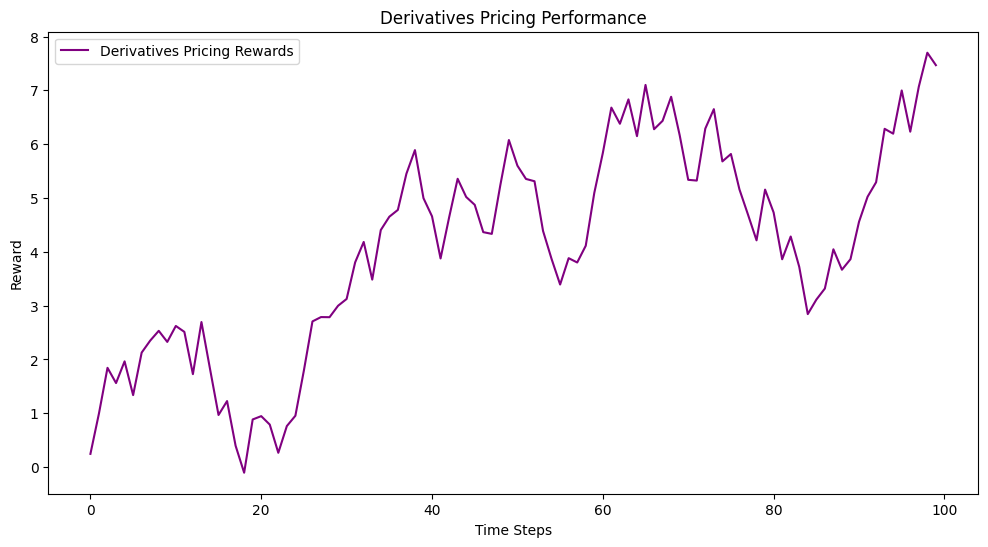

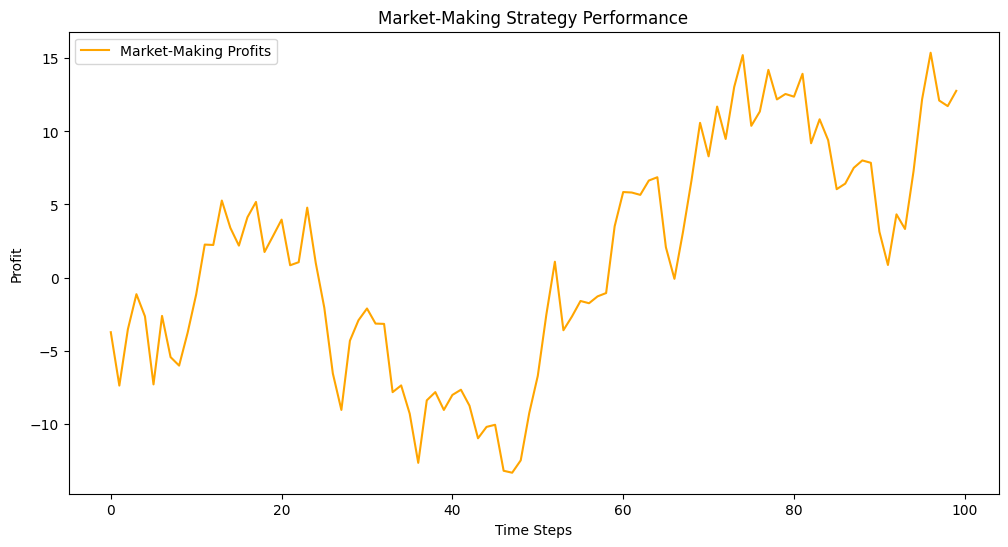

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Portfolio Value Visualization
def plot_portfolio_value(portfolio_values):
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Portfolio Value')
    plt.legend()
    plt.title("RL-Based Portfolio Optimization Performance")
    plt.xlabel("Time Steps")
    plt.ylabel("Portfolio Value")
    plt.show()

# Profitability Visualization
def plot_profitability(profits):
    plt.figure(figsize=(12, 6))
    plt.plot(profits, label='Cumulative Profit', color='green')
    plt.legend()
    plt.title("Profitability Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Cumulative Profit")
    plt.show()

# Execution Cost Visualization
def plot_execution_costs(execution_costs):
    plt.figure(figsize=(12, 6))
    plt.hist(execution_costs, bins=20, color='blue', alpha=0.7)
    plt.title("Distribution of Execution Costs")
    plt.xlabel("Execution Cost")
    plt.ylabel("Frequency")
    plt.show()

# Pricing Accuracy Visualization
def plot_price_accuracy(real_prices, predicted_prices):
    plt.figure(figsize=(12, 6))
    plt.plot(real_prices, label='Real Prices', color='blue')
    plt.plot(predicted_prices, label='Predicted Prices', linestyle='dashed', color='red')
    plt.legend()
    plt.title("Pricing Accuracy: Real vs. Predicted Prices")
    plt.xlabel("Time Steps")
    plt.ylabel("Price")
    plt.show()

# RL Environment for Portfolio Optimization Visualization
def plot_rl_portfolio_optimization(portfolio_values):
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='RL Portfolio Optimization')
    plt.legend()
    plt.title("Portfolio Optimization with RL")
    plt.xlabel("Time Steps")
    plt.ylabel("Portfolio Value")
    plt.show()

# Derivatives Pricing using RL Visualization
def plot_rl_derivatives_pricing(rewards):
    plt.figure(figsize=(12, 6))
    plt.plot(rewards, label='Derivatives Pricing Rewards', color='purple')
    plt.legend()
    plt.title("Derivatives Pricing Performance")
    plt.xlabel("Time Steps")
    plt.ylabel("Reward")
    plt.show()

# Market-Making Strategies using RL Visualization
def plot_rl_market_making(profits):
    plt.figure(figsize=(12, 6))
    plt.plot(profits, label='Market-Making Profits', color='orange')
    plt.legend()
    plt.title("Market-Making Strategy Performance")
    plt.xlabel("Time Steps")
    plt.ylabel("Profit")
    plt.show()

# Example data generation
portfolio_values = np.cumsum(np.random.uniform(-10, 10, 100))
profits = np.cumsum(np.random.uniform(-10, 10, 100))
execution_costs = np.random.uniform(0, 0.5, 100)
real_prices = np.random.uniform(50, 150, 100)
predicted_prices = real_prices + np.random.uniform(-5, 5, 100)
derivatives_rewards = np.cumsum(np.random.uniform(-1, 1, 100))
market_making_profits = np.cumsum(np.random.uniform(-5, 5, 100))

# Call visualization functions
plot_portfolio_value(portfolio_values)
plot_profitability(profits)
plot_execution_costs(execution_costs)
plot_price_accuracy(real_prices, predicted_prices)
plot_rl_portfolio_optimization(portfolio_values)
plot_rl_derivatives_pricing(derivatives_rewards)
plot_rl_market_making(market_making_profits)


In [4]:
import numpy as np
import pandas as pd


# Random seed for reproducibility
np.random.seed(42)


In [5]:
def simulate_portfolio_trading(steps=5):
    stock_prices = np.linspace(100, 120, steps)  # Simulated stock prices
    balance = 10000  # Initial cash balance
    shares_owned = 0
    actions = ['Buy', 'Hold', 'Hold', 'Sell', 'Buy']  # AI actions

    data = []
    for i in range(steps):
        action = actions[i]
        if action == 'Buy' and balance >= stock_prices[i]:
            shares_owned += balance // stock_prices[i]  # Buying shares
            balance %= stock_prices[i]  # Updating balance
        elif action == 'Sell' and shares_owned > 0:
            balance += shares_owned * stock_prices[i]  # Selling all shares
            shares_owned = 0  # Reset shares

        # Store in table
        data.append([f"T{i+1}", stock_prices[i], round(balance, 2), shares_owned, action])

    df = pd.DataFrame(data, columns=['Time', 'Stock Price', 'Balance', 'Shares Owned', 'AI Action'])
    
    print("\n📈 Portfolio Optimization Grid:")
    print(df.to_string(index=False))  # Print formatted table
    return df

# Generate and display Portfolio Optimization Grid
simulate_portfolio_trading()



📈 Portfolio Optimization Grid:
Time  Stock Price  Balance  Shares Owned AI Action
  T1        100.0      0.0         100.0       Buy
  T2        105.0      0.0         100.0      Hold
  T3        110.0      0.0         100.0      Hold
  T4        115.0  11500.0           0.0      Sell
  T5        120.0    100.0          95.0       Buy


,Time,Stock Price,Balance,Shares Owned,AI Action
0,T1,100.0,0.0,100.0,Buy
1,T2,105.0,0.0,100.0,Hold
2,T3,110.0,0.0,100.0,Hold
3,T4,115.0,11500.0,0.0,Sell
4,T5,120.0,100.0,95.0,Buy


In [6]:
def simulate_derivatives_pricing(steps=5):
    asset_prices = np.linspace(100, 96, steps)  # Simulated asset price changes
    hedge_ratio = 0.5  # Initial hedge ratio
    actions = ['+H', 'HH', '-H', 'HH', '+H']  # AI hedge actions
    pricing_errors = np.linspace(3.2, 0.8, steps)  # Simulated pricing error decrease

    data = []
    for i in range(steps):
        if actions[i] == '+H':
            hedge_ratio = min(hedge_ratio + 0.1, 1.0)  # Increase hedge
        elif actions[i] == '-H':
            hedge_ratio = max(hedge_ratio - 0.1, 0.0)  # Decrease hedge

        # Store in table
        data.append([f"T{i+1}", asset_prices[i], round(hedge_ratio, 2), actions[i], round(pricing_errors[i], 2)])

    df = pd.DataFrame(data, columns=['Time', 'Asset Price', 'Hedge Ratio', 'AI Action', 'Pricing Error'])
    
    print("\n📉 Derivatives Pricing Grid:")
    print(df.to_string(index=False))  # Print formatted table
    return df

# Generate and display Derivatives Pricing Grid
simulate_derivatives_pricing()



📉 Derivatives Pricing Grid:
Time  Asset Price  Hedge Ratio AI Action  Pricing Error
  T1        100.0          0.6        +H            3.2
  T2         99.0          0.6        HH            2.6
  T3         98.0          0.5        -H            2.0
  T4         97.0          0.5        HH            1.4
  T5         96.0          0.6        +H            0.8


,Time,Asset Price,Hedge Ratio,AI Action,Pricing Error
0,T1,100.0,0.6,+H,3.2
1,T2,99.0,0.6,HH,2.6
2,T3,98.0,0.5,-H,2.0
3,T4,97.0,0.5,HH,1.4
4,T5,96.0,0.6,+H,0.8


In [7]:
def simulate_market_making(steps=5):
    market_prices = np.linspace(100, 104, steps)  # Simulated market price movements
    bid_ask_spread = 1.0  # Initial spread
    trade_volumes = np.linspace(200, 225, steps)  # Simulated trade volume
    actions = ['+S', 'HS', '-S', 'HS', '+S']  # AI actions

    data = []
    for i in range(steps):
        if actions[i] == '+S':
            bid_ask_spread += 0.2  # Increase spread
        elif actions[i] == '-S':
            bid_ask_spread = max(0.8, bid_ask_spread - 0.2)  # Decrease spread

        # Store in table
        data.append([f"T{i+1}", market_prices[i], round(bid_ask_spread, 2), trade_volumes[i], actions[i]])

    df = pd.DataFrame(data, columns=['Time', 'Market Price', 'Bid-Ask Spread', 'Trade Volume', 'AI Action'])
    
    print("\n💵 Market Making Grid:")
    print(df.to_string(index=False))  # Print formatted table
    return df

# Generate and display Market Making Grid
simulate_market_making()



💵 Market Making Grid:
Time  Market Price  Bid-Ask Spread  Trade Volume AI Action
  T1         100.0             1.2        200.00        +S
  T2         101.0             1.2        206.25        HS
  T3         102.0             1.0        212.50        -S
  T4         103.0             1.0        218.75        HS
  T5         104.0             1.2        225.00        +S


,Time,Market Price,Bid-Ask Spread,Trade Volume,AI Action
0,T1,100.0,1.2,200.00,+S
1,T2,101.0,1.2,206.25,HS
2,T3,102.0,1.0,212.50,-S
3,T4,103.0,1.0,218.75,HS
4,T5,104.0,1.2,225.00,+S
